In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import jax
import jax.numpy as jnp
import genjax
import rerun as rr

In [35]:
from tracking.model import model_factory, rerun_log_trace

In [36]:
PORT = 8812
rr.init("tracking")
rr.connect(addr=f'127.0.0.1:{PORT}')

In [41]:
model = model_factory(
    max_T = 100,
    width = 50,
    height = 40,
    pose_kernel_params = (1.0, 1.0),
    max_keypoint_mesh_width = 4,
    max_keypoint_mesh_height = 4,
    max_depth = 20.0
)

key = jax.random.PRNGKey(3)
trace = model.simulate(key, (10,))

In [42]:
rerun_log_trace(trace)

In [15]:
from tracking.mesh import Mesh

# sq = jax.vmap(
#     lambda x: Mesh.square_mesh([0., 0.], [x, x], jnp.array([0., 0., 0., 1.]))
# )(jnp.array([20., 30.]))

sq = Mesh.square_mesh(jnp.array([0., 0.]), jnp.array([20., 20.]), jnp.array([0., 0., 0., 1.]))

def render_mesh(mesh, pose):
    return mesh.to_image(
            jnp.zeros(3),
            64, 64,
            lambda rgbd: rgbd[-1],
            jnp.array([1., 1., 1., 10.])
        )

img = jax.vmap(render_mesh, in_axes=(None, 0))(sq, jnp.zeros((2, 3)))
img[0].shape

(2, 64, 64, 4)

In [47]:
from tracking.mesh import Mesh

sq = Mesh.square_mesh(jnp.array([1., 0.]), jnp.array([20., 20.]), jnp.array([0., 0., 0., 1.]))

img = sq.to_image(jnp.zeros(3), 21, 21,
        lambda rgbd: rgbd[-1],
        jnp.array([1., 1., 1., 10.])
    )

img[0].shape

(21, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


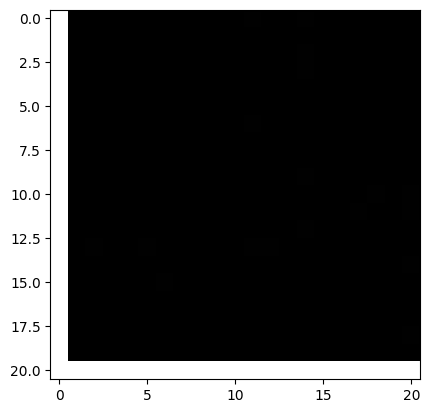

In [48]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [124]:
width, height = 20, 20
bottom_lefts = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
bottom_lefts = jnp.stack(bottom_lefts, axis=-1).reshape(-1, 2)
bottom_lefts.shape

(400, 2)

In [131]:
from tracking.mesh import Mesh

In [132]:
width, height = 12, 15
attributes = jnp.ones((width, height, 4))

In [133]:
bottom_lefts = jnp.meshgrid(jnp.arange(width), jnp.arange(height))
bottom_lefts = jnp.stack(bottom_lefts, axis=-1).reshape(-1, 2)
widthheights = jnp.ones((width * height, 2))
attributes = attributes.reshape((-1, attributes.shape[-1]))


In [135]:
vmapped_mesh = jax.vmap(Mesh.square_mesh, in_axes=(0, 0, 0))(bottom_lefts, widthheights, attributes)


In [136]:
vertices = vmapped_mesh.vertices.reshape((-1, 2))
n_vertices_per_face = vmapped_mesh.vertices.shape[1]


In [143]:
vmapped_mesh.faces.shape

(180, 2, 3)

In [144]:
# Generate the base array
# arr = jnp.arange(vertices.shape[0])




Array([[  0,   1,   2],
       [  0,   2,   3],
       [  0,   1,   2],
       ...,
       [356, 358, 359],
       [356, 357, 358],
       [356, 358, 359]], dtype=int32)